# Structured Tasks
## Set up Dependencies and Data files

In [ ]:
from google.colab import drive
import requests
import pandas as pd
from io import StringIO
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import csv

import statsmodels.api as sm
import seaborn as sns
from collections import defaultdict
from statsmodels.gam.api import GLMGam, BSplines, CyclicCubicSplines
from statsmodels.tools.eval_measures import mse

!pip install datasets
!pip install nltk
from datasets import load_dataset
from nltk.util import ngrams
from nltk.lm.preprocessing import pad_both_ends, padded_everygram_pipeline as pad_pipe
from nltk.lm import MLE, Lidstone
import re

In [ ]:
drive.mount('/content/gdrive')
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_1"

Mounted at /content/gdrive


In [ ]:
%%bash
git clone https://github.com/omershubi/neural-complexity.git rnn
mkdir -p rnn/data/ptb
wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
mkdir -p "$GDRIVE_DIR"
mkdir -p "$GDRIVE_DIR/corpus_data"
cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

Cloning into 'rnn'...
mkdir: cannot create directory ‘’: No such file or directory


In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"
brown_txt = "/content/rnn/data/brown.txt"
brown_RTs = "/content/rnn/data/brown-spr-data-for-pset.csv"
brown_surprisals = GDRIVE_DIR + "/rnn_brown_surprisals.tsv"
harmonized_ngram_url = "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/harmonized_ngram.csv"

## Train RNN model and compute brown suprisals

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

| epoch  40 |  1200/ 1422 batches | lr 2.00 | ms/batch 12.49 | loss  4.99 | ppl   146.93
| epoch  40 |  1400/ 1422 batches | lr 2.00 | ms/batch 12.52 | loss  5.02 | ppl   150.72
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 17.99s | lr: 2.00000000 | valid ppl   149.68
-----------------------------------------------------------------------------------------


In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$brown_surprisals"

Libraries loaded
Using beamsize: 23757


## Load, Harmonize, and Merge RNN & n-Gram suprisal files

In [ ]:
harmonized_ngram_text = requests.get(harmonized_ngram_url).text
harmonized_ngram = pd.read_csv(StringIO(harmonized_ngram_text))
rnn_surprisals = pd.read_csv(brown_surprisals, delimiter=' ')
rnn_surp_tokens = rnn_surprisals

In [ ]:
rnn_surprisals = rnn_surprisals[rnn_surprisals['word'] != '<s>']
rnn_surprisals = rnn_surprisals[rnn_surprisals['word'] != '</s>']
rnn_surprisals = rnn_surprisals[rnn_surprisals['word'] != '<unk>']
rnn_surprisals = rnn_surprisals[rnn_surprisals['word'] != '--']
rnn_surprisals = rnn_surprisals.drop(4504).reset_index()

In [ ]:
merged_data = harmonized_ngram.merge(rnn_surprisals, right_index=True, left_index=True)
merged_data = merged_data.drop(columns=['word_y',
                                        'Unnamed: 0',
                                        'word_x',
                                        'code',
                                        'subject',
                                        'text_id',
                                        'index',
                                        'time'])
merged_data = merged_data.rename(columns={'surp': 'rnn_surprisal',
                                          'surprisal': 'ngram_surprisal'})

In [ ]:
merged_data.head(4)

,sentence_id,token_id,token,ngram_surprisal,text_pos,word_in_exp,mean_subject,std_subject,mean_time,sentid,sentpos,wlen,rnn_surprisal,entropy,entred
0,1,1,In,4.57937,0,2285,404.314216,140.637253,350.145625,0,0,2,5.506053,9.515585,0.000000
1,1,3,County,12.65410,2,2287,404.314216,140.637253,296.042941,0,2,6,12.514248,6.056062,1.810063
2,1,5,near,12.22380,4,1256,258.514553,57.809393,348.327500,0,4,4,13.308077,8.640187,0.000000
3,1,6,the,1.98095,5,3293,244.965341,77.419010,306.075882,0,5,3,1.662673,7.870934,0.769253


## Compare n-gram and RNN models
### Question 1
Which model has surprisal estimates which correlate better with human reading times?

In [ ]:
# compute the correlation coefficients between surprisal estimates and human reading times
rnn_corr = stats.pearsonr(merged_data['rnn_surprisal'], merged_data['mean_time'])[0]
ngram_corr = stats.pearsonr(merged_data['ngram_surprisal'], merged_data['mean_time'])[0]

print(f"RNN suprisals correlation to reading time: {rnn_corr}")
print(f"n-gram surprisals correlation to reading time: {ngram_corr}")

RNN suprisals correlation to reading time: 0.2020939454327774
n-gram surprisals correlation to reading time: 0.19996728191611632


The RNN model has a slightly better correlation with human reading times, 0.202, compared to the n-gram model's 0.199, but the difference is very slight.

### Question 2
Plot the relationship between the n-gram model’s surprisal estimate for a word and the RNN’s estimate. Each point in the graph should correspond to a single token from the harmonized data. Describe what you see in this graph. Are the models generally well matched? On what parts of the surprisal spectrum do they disagree?

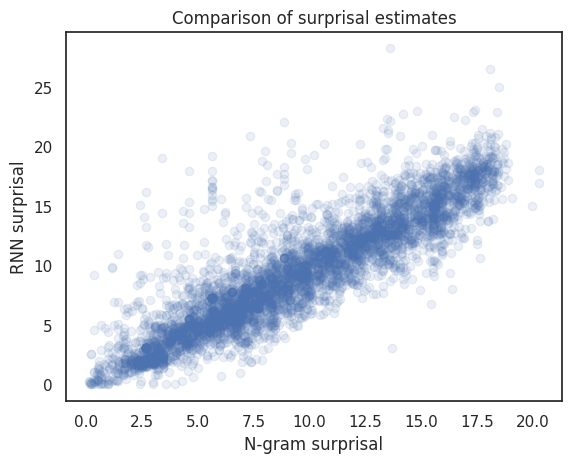

In [ ]:
plt.scatter(merged_data['ngram_surprisal'], merged_data['rnn_surprisal'], alpha=0.1)
plt.xlabel('N-gram surprisal')
plt.ylabel('RNN surprisal')
plt.title('Comparison of surprisal estimates')
plt.show()

The graph shows a very high correlation between the n-gram surprisal values and the RNN model's surprisal values. We can conclude that the models are indeed well-matched, although there seem to be more outliers among words for which the n-gram model estimated a low surprisal value and the RNN model a higher one.

Based on the graph, the RNN model seems to assign greater surprisal values than the n-gram model. We'll plot this difference:

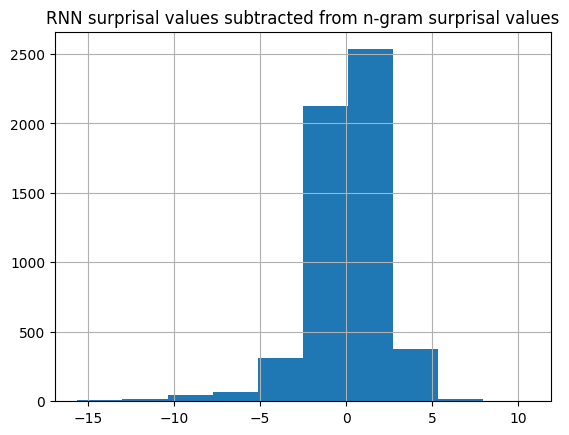

In [ ]:
merged_data['difference'] = merged_data['ngram_surprisal'] - merged_data['rnn_surprisal']
merged_data.hist('difference')
plt.title("RNN surprisal values subtracted from n-gram surprisal values")
plt.show()

Unlike our estimate based on the previous graph, there does not appear to be a clear trend of lower RNN values compared to n-gram values, however there do appear to be some extreme outliers for whom the RNN values is much greater, which is probably the cause of our false initial perception.

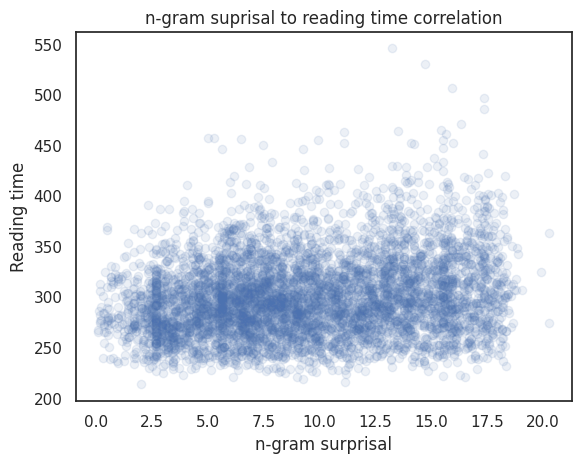

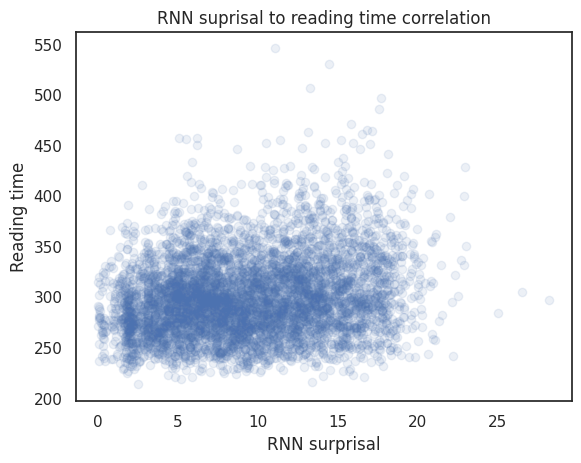

In [ ]:
plt.scatter(merged_data['ngram_surprisal'], merged_data['mean_time'],alpha=0.1)
plt.xlabel('n-gram surprisal')
plt.ylabel('Reading time')
plt.title('n-gram suprisal to reading time correlation')
plt.show()

plt.scatter(merged_data['rnn_surprisal'], merged_data['mean_time'],alpha=0.1)
plt.xlabel('RNN surprisal')
plt.ylabel('Reading time')
plt.title('RNN suprisal to reading time correlation')
plt.show()

### Question 3
Pick specific interesting points from this graph (for example, points where the two models have very different surprisal estimates) and report the sentences containing the corresponding tokens. Why do you think the models should disagree?

We'll check the extreme outliers found in the previous graph:

In [ ]:
POIs = merged_data[(merged_data['difference']) < -14]
print("Points of Interst\n" + "-" * 17)
for index, row in POIs.iterrows():
  sentence_id = row['sentence_id']
  token_id = row['token_id']
  sentence = harmonized_ngram[harmonized_ngram['sentence_id'] == sentence_id]
  token = row['token']

  print(f"Token:\t\t{token}\nSentence:\t{' '.join(sentence['token'])}\n" + "-" * 9)

Points of Interst
-----------------
Token:		John
Sentence:	She was the John one of those Atlantic that had sailed to to bring and bullets to the U.S.
---------
Token:		I
Sentence:	Down in New was a flier in the right place at the right Robert S. a native New had been a World War I flying and one of the original planners of the Concord
---------


Note that the sentences appear without unique words that were replaced by a <unk> token.

### Question 4
Examine **spillover** in both models: look at the relationship between word probability and the next word’s reading time (a “spillover” effect). Is the effect similar as on the current word? Bigger? Smaller? Different shape? Are the spillover effects different across the two models?

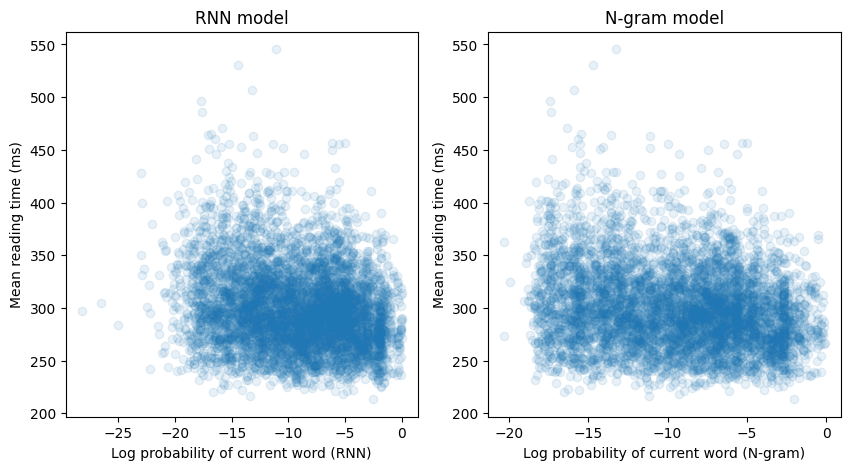

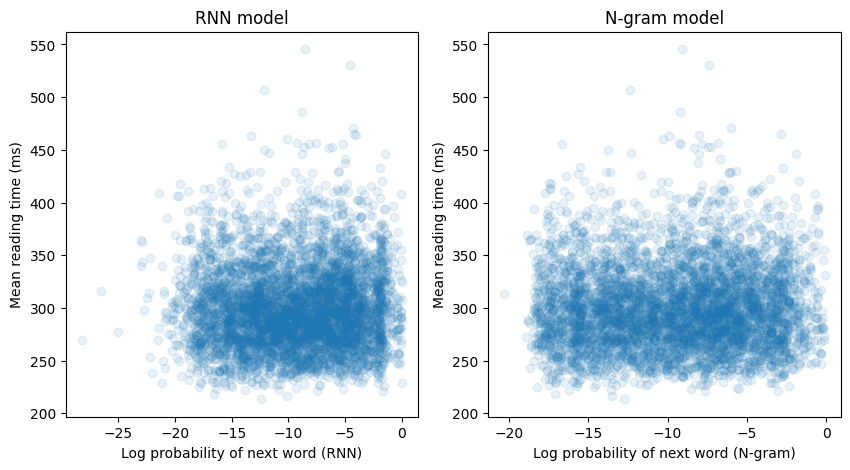

In [ ]:
# create new columns for log probabilities
merged_data["log_rnn_prob"] = -merged_data.rnn_surprisal # negative surprisal is equivalent to log probability
merged_data["log_ngram_prob"] = -merged_data.ngram_surprisal

# create a new column for the next word's log probability, by shifting the values by one row within each sentence
merged_data["log_rnn_prob_next"] = merged_data.groupby("sentid")["log_rnn_prob"].shift(-1)
merged_data["log_ngram_prob_next"] = merged_data.groupby("sentid")["log_ngram_prob"].shift(-1)

# group by sentid and sentpos, and calculate the mean reading time for each word position
mean_time = merged_data.groupby(["sentid", "sentpos"])["mean_time"].mean().reset_index()

# merge the mean time with the original dataframe, to get the log probabilities for each word position
merged = pd.merge(merged_data, mean_time, on=["sentid", "sentpos"], suffixes=("_orig", "_mean"))

# plot the mean reading time against the log probability of the current word, separately for each model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(merged.log_rnn_prob, merged.mean_time_mean, alpha=0.1)
plt.xlabel("Log probability of current word (RNN)")
plt.ylabel("Mean reading time (ms)")
plt.title("RNN model")
plt.subplot(1, 2, 2)
plt.scatter(merged.log_ngram_prob, merged.mean_time_mean, alpha=0.1)
plt.xlabel("Log probability of current word (N-gram)")
plt.ylabel("Mean reading time (ms)")
plt.title("N-gram model")
plt.show()

# plot the mean reading time against the log probability of the next word, separately for each model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(merged.log_rnn_prob_next, merged.mean_time_mean, alpha=0.1)
plt.xlabel("Log probability of next word (RNN)")
plt.ylabel("Mean reading time (ms)")
plt.title("RNN model")
plt.subplot(1, 2, 2)
plt.scatter(merged.log_ngram_prob_next, merged.mean_time_mean, alpha=0.1)
plt.xlabel("Log probability of next word (N-gram)")
plt.ylabel("Mean reading time (ms)")
plt.title("N-gram model")
plt.show()


The ratio between the log-probability and the mean reading time appears to be very similar between the current word and the next word's reading time, which would indicate that the spillover effect applies. The effect exists for both models, but the shape of the ratio's distribution is different, with the log-probabilities of the n-gram model having a greater variance than the RNN's while having similar reading times.

# Semi-Structured Tasks
### Task 1
Fit and plot the RT surprisal curve using a General Additive Model (GAM). The model should include control variables for log-frequency and word length. Examine both current word and spillover effects.

In [ ]:
sns.set(style="white", color_codes=True)

merged_data['ngram_prob'] = np.power(2, -merged_data['ngram_surprisal'])
merged_data['rnn_prob'] = np.power(2, -merged_data['rnn_surprisal'])
spillover = merged_data.iloc[:-1].reset_index()
merged_data['spillover'] = merged_data['mean_time'].iloc[1:].reset_index(drop=True)

with open(brown_txt, 'r', encoding='utf8') as file:
  s = file.read().split(' ')
  log_freq = defaultdict(lambda: 0)
  for word in s:
    log_freq[word] += 1
  for word in log_freq:
    log_freq[word] = np.log2(log_freq[word])
merged_data['log_freq'] = merged_data['token'].map(log_freq)

Current word:

                 Generalized Linear Model Regression Results                  
Dep. Variable:              mean_time   No. Observations:                 5500
Model:                         GLMGam   Df Residuals:                     5490
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1398.7
Method:                         PIRLS   Log-Likelihood:                -27718.
Date:                Mon, 10 Jul 2023   Deviance:                   7.6787e+06
Time:                        18:50:25   Pearson chi2:                 7.68e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.07496
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              260.8834      4.731  

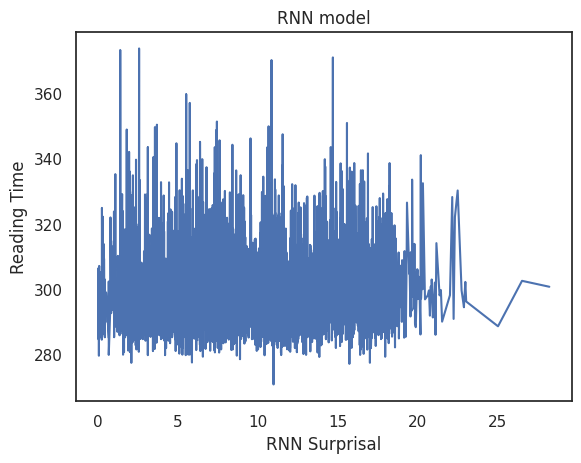

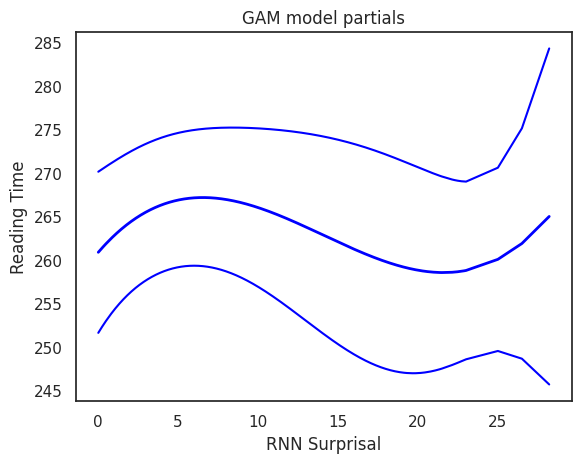

In [ ]:
def plot_gam_model(x, y, xlabel, ylabel='Reading Time'):
  x = sm.add_constant(x)
  bs = BSplines(x, df=[4, 4, 4, 4], degree=[3, 3, 3, 3])
  gam_model = GLMGam(y, x, smoother=bs).fit()
  print(gam_model.summary())
  print('MSE:', mse(y, gam_model.predict(x,x)))
  plt.plot(x.iloc[:, 1].sort_values(), gam_model.predict(x,x))
  plt.title('RNN model')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  gam_model.plot_partial(1)
  plt.title('GAM model partials')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

plot_gam_model(merged_data[['rnn_surprisal', 'log_freq', 'wlen']],
               merged_data['mean_time'],
               'RNN Surprisal')

Next word (spillover):

                 Generalized Linear Model Regression Results                  
Dep. Variable:              spillover   No. Observations:                 5499
Model:                         GLMGam   Df Residuals:                     5489
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1458.9
Method:                         PIRLS   Log-Likelihood:                -27829.
Date:                Mon, 10 Jul 2023   Deviance:                   8.0079e+06
Time:                        18:50:26   Pearson chi2:                 8.01e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03282
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              281.0405      4.833  

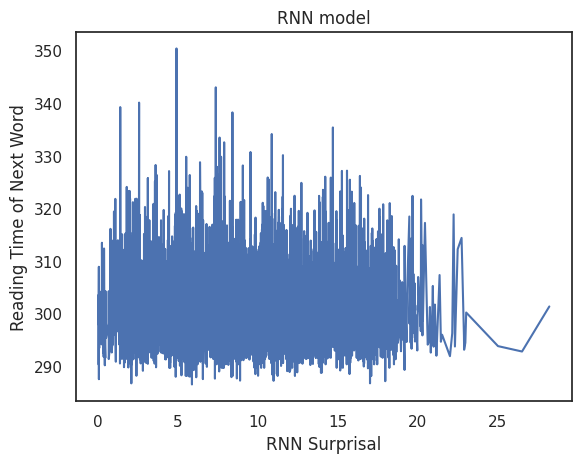

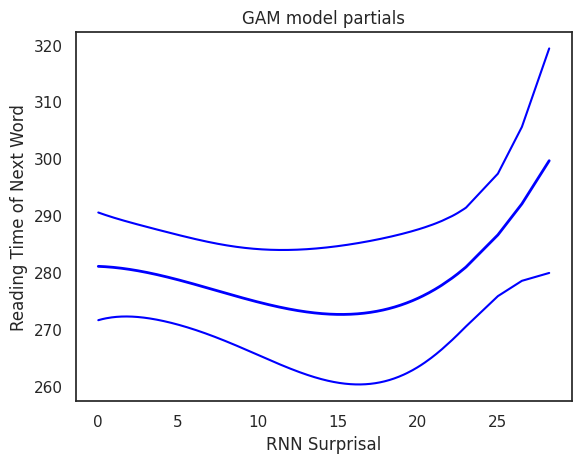

In [ ]:
plot_gam_model(merged_data.iloc[:-1, :][['rnn_surprisal', 'log_freq', 'wlen']],
               merged_data.iloc[:-1, :]['spillover'],
               'RNN Surprisal',
               'Reading Time of Next Word')

### Task 2
Choose a different reading times corpus (self-paced reading, eye-tracking, or maze), compute surprisals for this corpus using the RNN model from the structured task, and analyze the RT-surprisal relationship, including spillover. Compare the results to those you obtained with the self-paced reading corpus of Smith and Levy (2013) used in HW2 and the structured task.

In [ ]:
!wget -qO rnn/data/processed_RTs.tsv https://raw.githubusercontent.com/languageMIT/naturalstories/master/naturalstories_RTS/processed_RTs.tsv

original_f = "rnn/data/processed_RTs.tsv"

with open(original_f) as f:
  tsv = csv.reader(f, delimiter="\t")
  processedRT = [line for line in tsv]

meanPRT = [processedRT[i] for i in range(len(processedRT)) if i != 0 and processedRT[i][4] != processedRT[i - 1][4]]

PRTWords = []
temp = []
for line in meanPRT:
  if line[4] == "1" and len(temp) != 0:
    PRTWords.append(temp)
    temp = []
  temp.append(line[6])
PRTWords.append(temp)

outStr = "\n\n".join([" ".join(paragraph) for paragraph in PRTWords])
croppedPRT = [[line[6], line[8]] for line in meanPRT]

with open('rnn/data/self_paced_processed_RTs.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(["word", "ReadingTime"])
    for row in croppedPRT:
        csv_out.writerow(row)

with open('rnn/data/self_paced_text.txt','w') as out:
  out.write(outStr)

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'self_paced_text.txt' --test --words --nopp > "self-paced_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


In [ ]:
sprnn_surprisals = pd.read_csv("rnn/self-paced_surprisals.tsv", delimiter=' ')
sp_RTs = pd.read_csv("rnn/data/self_paced_processed_RTs.csv")

sp_data = sp_RTs.merge(sprnn_surprisals, right_index=True, left_index=True)
sp_data = sp_data.rename(columns={'surp': 'rnn_surprisal',
                                  'ReadingTime': 'mean_time'})
sp_data

,word_x,mean_time,word_y,sentid,sentpos,wlen,rnn_surprisal,entropy,entred
0,If,369.011905,If,0,0,2,6.633799,9.515585,0.000000
1,you,368.183908,you,0,1,3,6.123430,6.663960,2.851624
2,were,344.318182,were,0,2,4,4.394970,7.132514,0.000000
3,to,354.639535,to,0,3,2,5.547862,9.795667,0.000000
4,journey,349.674157,journey,0,4,7,21.106024,8.359248,1.436419
...,...,...,...,...,...,...,...,...,...
10251,and,317.414286,and,407,11,3,2.974109,3.699198,5.841850
10252,better,335.267606,better,407,12,6,12.725901,11.445158,0.000000
10253,treatments,359.861111,treatments,407,13,10,14.957111,8.406811,3.038347
10254,for,506.728571,for,407,14,3,5.513323,2.844426,5.562385


In [ ]:
# compute the correlation coefficients between surprisal estimates and human reading times
rnn_corr = stats.pearsonr(sp_data['rnn_surprisal'], sp_data['mean_time'])[0]

print(f"RNN suprisals correlation to reading time: {rnn_corr}")

RNN suprisals correlation to reading time: 0.015120480117041299


The correlation between the surprisal values and the reading time is 0.0152, and is lower than the 0.0202 correlation obtained using the previous corpus.

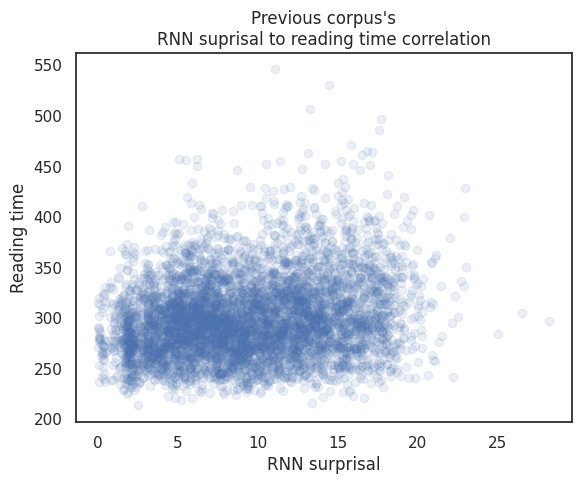

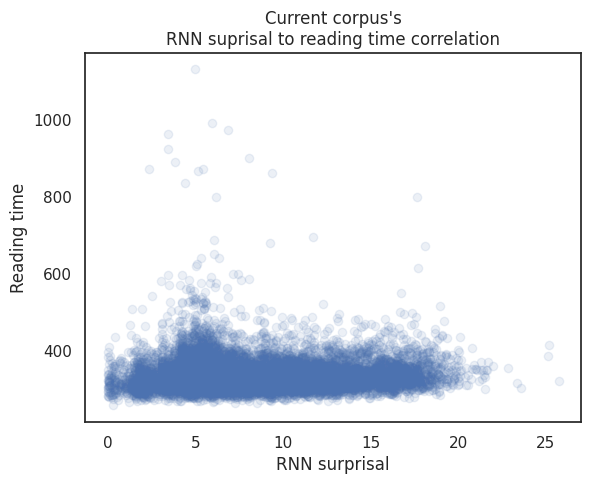

In [ ]:
plt.scatter(merged_data['rnn_surprisal'], merged_data['mean_time'], alpha=0.1)
plt.xlabel('RNN surprisal')
plt.ylabel('Reading time')
plt.title('Previous corpus\'s\nRNN suprisal to reading time correlation')
plt.show()

plt.scatter(sp_data['rnn_surprisal'], sp_data['mean_time'], alpha=0.1)
plt.xlabel('RNN surprisal')
plt.ylabel('Reading time')
plt.title('Current corpus\'s\nRNN suprisal to reading time correlation')
plt.show()

The suprisal values for the current corpus seem for the most part similar to that of the previous corpus, but there is an area centered around a suprisal value of 5 in which there is a great concentration of outliers which does not exist in the original corpus.

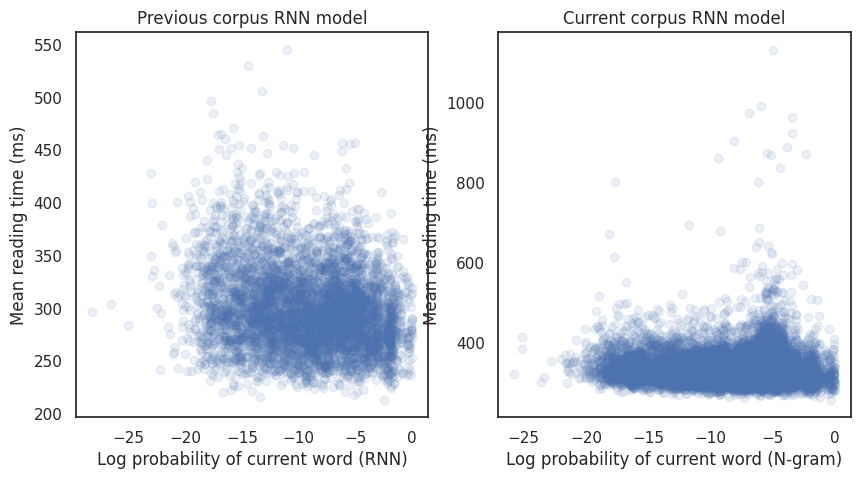

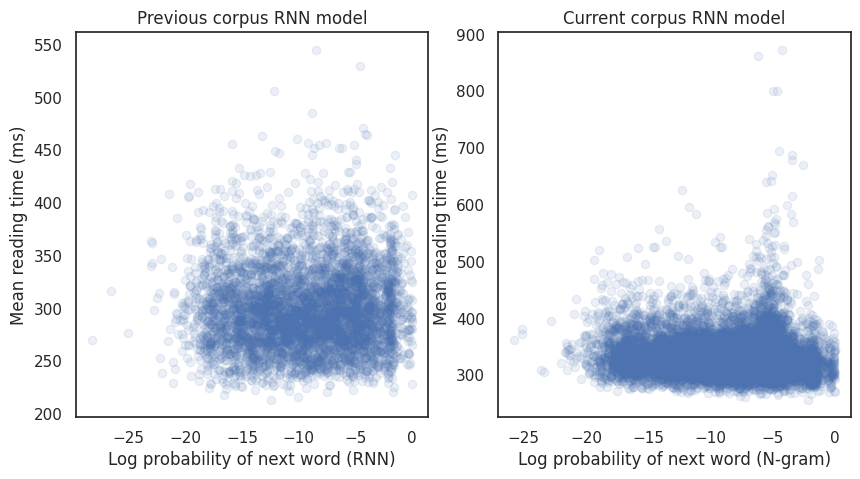

In [ ]:
# create new columns for log probabilities
sp_data["log_rnn_prob"] = -sp_data.rnn_surprisal # negative surprisal is equivalent to log probability

# create a new column for the next word's log probability, by shifting the values by one row within each sentence
sp_data["log_rnn_prob_next"] = sp_data.groupby("sentid")["log_rnn_prob"].shift(-1)

# group by sentid and sentpos, and calculate the mean reading time for each word position
sp_mean_time = sp_data.groupby(["sentid", "sentpos"])["mean_time"].mean().reset_index()

# merge the mean time with the original dataframe, to get the log probabilities for each word position
sp_merged = pd.merge(sp_data, sp_mean_time, on=["sentid", "sentpos"], suffixes=("_orig", "_mean"))

# plot the mean reading time against the log probability of the current word, separately for each model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(merged.log_rnn_prob, merged.mean_time_mean, alpha=0.1)
plt.xlabel("Log probability of current word (RNN)")
plt.ylabel("Mean reading time (ms)")
plt.title("Previous corpus RNN model")
plt.subplot(1, 2, 2)
plt.scatter(sp_merged.log_rnn_prob, sp_merged.mean_time_mean, alpha=0.1)
plt.xlabel("Log probability of current word (N-gram)")
plt.ylabel("Mean reading time (ms)")
plt.title("Current corpus RNN model")
plt.show()

# plot the mean reading time against the log probability of the next word, separately for each model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(merged.log_rnn_prob_next, merged.mean_time_mean, alpha=0.1)
plt.xlabel("Log probability of next word (RNN)")
plt.ylabel("Mean reading time (ms)")
plt.title("Previous corpus RNN model")
plt.subplot(1, 2, 2)
plt.scatter(sp_merged.log_rnn_prob_next, sp_merged.mean_time_mean, alpha=0.1)
plt.xlabel("Log probability of next word (N-gram)")
plt.ylabel("Mean reading time (ms)")
plt.title("Current corpus RNN model")
plt.show()


Similarly to the results in the structured part, the spill over appears to apply, and the shape of the ratios' distribution is different between both models. The difference parallels the difference between the reading time to suprisal graphs of the two corpuses.

### Task 3
Train n-gram and RNN models on a larger dataset, such as Wikitext-2, Wikitext-103, and/or a still larger dataset (note that training larger models on Colab might require some careful checkpointing work), and see what happens to the relationship with RTs.

In [ ]:
# Load wikitext-2 as training file
train = load_dataset("wikitext", "wikitext-2-raw-v1", split="all")
train_sents = [sent.strip().lower() for sent in train["text"]]
train_sents = [re.sub(r'[^\w\s]','',s).split() for s in train_sents]
train_data, padded_sents_train = pad_pipe(5, train_sents)

# load brown.txt as testing file
with open(brown_txt, 'r') as f:
  test_sents = [sent.strip().lower() for sent in f.read().split('.')]
  test_sents = [re.sub(r'[^\w\s]','',s).split() for s in test_sents]
  test_data, padded_sents_test = pad_pipe(5, test_sents)
  padded_test_list = list(padded_sents_test)

# load brown readtimes
with open(brown_RTs, 'r') as f:
  csvreader = csv.reader(f)
  brown_readtime_data = list(csvreader)

In [ ]:
def calculate_suprisals(train_data, padded_sents_train, padded_val_list, readtime_data):
    # Train a 5-gram model and compute the surprisals of each word
    fivegram = Lidstone(order=5, gamma=0.0025)
    fivegram.fit(train_data, padded_sents_train)

    word_suprisals = []
    for i in range(4, len(padded_val_list)):
      word_suprisals.append([padded_val_list[i],
       (-fivegram.logscore(padded_val_list[i], padded_val_list[i-4: i]))])
    word_suprisals = [sup for sup in word_suprisals if sup[0] not in ["<s>", "</s>"]]

    # Use the sentence_perplexity_surprisal method of the model to get the word surprisals
    word_suprisals.insert(0, ['word', 'surprisal'])

    for rd, ws in zip(readtime_data, word_suprisals):
      rd.extend(ws)
    print(readtime_data[0])

    # Return the merged dataframe
    return readtime_data

In [ ]:
fivegram_RTs = calculate_suprisals(train_data,
                                   padded_sents_train,
                                   padded_test_list,
                                   brown_readtime_data)

with open("fivegram_wikitext_suprisals.csv", 'w') as f:
  csvwriter = csv.writer(f)
  csvwriter.writerows(fivegram_RTs)

['', 'word', 'code', 'subject', 'text_id', 'text_pos', 'word_in_exp', 'time', 'word', 'surprisal']


In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/wiki_vocab.txt" \
    --tied --data_dir "/content/rnn/data/wikitext-2" --trainfname train.txt --validfname valid.txt

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/wiki_model.pt" \
    --vocab_file "$GDRIVE_DIR/wiki_vocab.txt" --data_dir "/content/rnn/data/wikitext-2" \
    --testfname '/content/rnn/data/brown.txt' --test --words --nopp > "/content/rnn_wikitext_suprisals.csv"

Libraries loaded
Using beamsize: 33278


In [ ]:
fivegram_suprisals = pd.read_csv("/content/fivegram_wikitext_suprisals.csv")
rnn_surprisals = pd.read_csv("/content/rnn_wikitext_suprisals.csv", delimiter=' ')

<ipython-input-57-ba161b48efa7>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  fivegram_suprisals = pd.read_csv("/content/fivegram_wikitext_suprisals.csv")
